# Telecom Provider

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts. <br/>
The contract information is valid as of February 1, 2020.

In [1]:
import pandas as pd #import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

## Exploratory data analysis

In [2]:
contract = pd.read_csv('contract.csv', index_col=['customerID']) #read files as dataframes
internet = pd.read_csv('internet.csv',index_col=['customerID'])
personal = pd.read_csv('personal.csv',index_col=['customerID'])
phone = pd.read_csv('phone.csv', index_col=['customerID'])

### General Info

In [3]:
contract.info() #first look at the data, types, column names, number of observations

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


In [4]:
contract.sample(5) #sample to see the values

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
1641-RQDAY,2017-06-01,No,Month-to-month,Yes,Electronic check,100.40,3217.65
8612-GXIDD,2019-02-01,No,Two year,Yes,Bank transfer (automatic),25.40,313
0505-SPOOW,2014-04-01,No,Two year,No,Bank transfer (automatic),19.80,1397.65
3099-OONVS,2018-01-01,No,Month-to-month,No,Electronic check,54.30,1296.8
9867-JCZSP,2018-09-01,No,One year,No,Mailed check,20.75,418.25


In [5]:
internet.info() #same for internet table

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(7)
memory usage: 344.8+ KB


In [6]:
internet.describe()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


In [7]:
personal.describe(include='object')

,gender,Partner,Dependents
count,7043,7043,7043
unique,2,2,2
top,Male,No,No
freq,3555,3641,4933


In [8]:
phone.describe()

,MultipleLines
count,6361
unique,2
top,No
freq,3390


In [9]:
contract['EndDate'].describe() #what this column contains?

count     7043
unique       5
top         No
freq      5174
Name: EndDate, dtype: object

In [10]:
contract.groupby('EndDate').count() #what values are there? how do they split?

,BeginDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
EndDate,,,,,,
2019-10-01 00:00:00,458,458,458,458,458,458
2019-11-01 00:00:00,485,485,485,485,485,485
2019-12-01 00:00:00,466,466,466,466,466,466
2020-01-01 00:00:00,460,460,460,460,460,460
No,5174,5174,5174,5174,5174,5174


In [11]:
# the average monthly charge for who left is higher! interesting...
len(contract[contract['EndDate']=='No'])/len(contract) #precentage of customers who left.

0.7346301292063041

In [12]:
contract['TotalCharges'].sort_values().head(20) #checking why this column is not numeric

customerID
5709-LVOEQ           
3213-VVOLG           
2520-SGTTA           
3115-CZMZD           
2923-ARZLG           
7644-OMVMY           
2775-SEFEE           
4075-WKNIU           
1371-DWPAZ           
4472-LVYGI           
4367-NUYAO           
6180-YBIQI      100.2
3178-FESZO     100.25
2587-YNLES     100.35
7802-EFKNY      100.4
7216-EWTRS      100.8
4719-UMSIY      100.9
8104-OSKWT     1001.2
7009-PCARS     1001.5
6705-LNMDD    1003.05
Name: TotalCharges, dtype: object

## Missing values

In [13]:
contract[contract['TotalCharges']==' '] # checking the empty total cherge variables

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,


In [14]:
#All of them just started on the 1-2-20 so we can delete them because they dont have any additional information.
contract = contract[contract['TotalCharges']!=' ']
contract['TotalCharges'] = contract['TotalCharges'].astype('float')
contract['left'] = contract['EndDate'].apply(lambda x: 0 if x=='No' else 1) # target column
contract['BeginDate'] = pd.to_datetime(contract['BeginDate']) #changing the type
contract['duration'] = pd.to_numeric(pd.to_datetime(contract['EndDate'].apply(
    lambda x: '2020-02-01' if x=='No' else x)) - contract['BeginDate']) #duration od the subscrition

## Contract Dataset

In [15]:
pd.get_dummies(contract.drop(['EndDate','BeginDate','left'], axis=1), drop_first=True).corrwith(contract['left']) #correlations

MonthlyCharges                           0.192858
TotalCharges                            -0.199484
duration                                -0.354496
Type_One year                           -0.178225
Type_Two year                           -0.301552
PaperlessBilling_Yes                     0.191454
PaymentMethod_Credit card (automatic)   -0.134687
PaymentMethod_Electronic check           0.301455
PaymentMethod_Mailed check              -0.090773
dtype: float64

In [16]:
pd.get_dummies(contract.drop(['EndDate','BeginDate'], axis=1), drop_first=True).corr() #correlations

,MonthlyCharges,TotalCharges,left,duration,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
MonthlyCharges,1.000000,0.651065,0.192858,0.246715,0.004810,-0.073256,0.351930,0.030055,0.271117,-0.376568
TotalCharges,0.651065,1.000000,-0.199484,0.825811,0.170569,0.358036,0.157830,0.182663,-0.060436,-0.294708
left,0.192858,-0.199484,1.000000,-0.354496,-0.178225,-0.301552,0.191454,-0.134687,0.301455,-0.090773
duration,0.246715,0.825811,-0.354496,1.000000,0.202418,0.563814,0.004729,0.232827,-0.210301,-0.232083
Type_One year,0.004810,0.170569,-0.178225,0.202418,1.000000,-0.288843,-0.052278,0.067590,-0.109546,0.000197
Type_Two year,-0.073256,0.358036,-0.301552,0.563814,-0.288843,1.000000,-0.146281,0.174410,-0.281147,-0.007423
PaperlessBilling_Yes,0.351930,0.157830,0.191454,0.004729,-0.052278,-0.146281,1.000000,-0.013726,0.208427,-0.203981
PaymentMethod_Credit card (automatic),0.030055,0.182663,-0.134687,0.232827,0.067590,0.174410,-0.013726,1.000000,-0.373978,-0.285583
PaymentMethod_Electronic check,0.271117,-0.060436,0.301455,-0.210301,-0.109546,-0.281147,0.208427,-0.373978,1.000000,-0.386971
PaymentMethod_Mailed check,-0.376568,-0.294708,-0.090773,-0.232083,0.000197,-0.007423,-0.203981,-0.285583,-0.386971,1.000000


* The is a positive correlation with the monthly charges. people that pay less are more likely to leave - maybe they supscribe for less products so they are less depend on the company. 
* Duration is also negative - as expected.
* For the payment method - not surprising as well. 

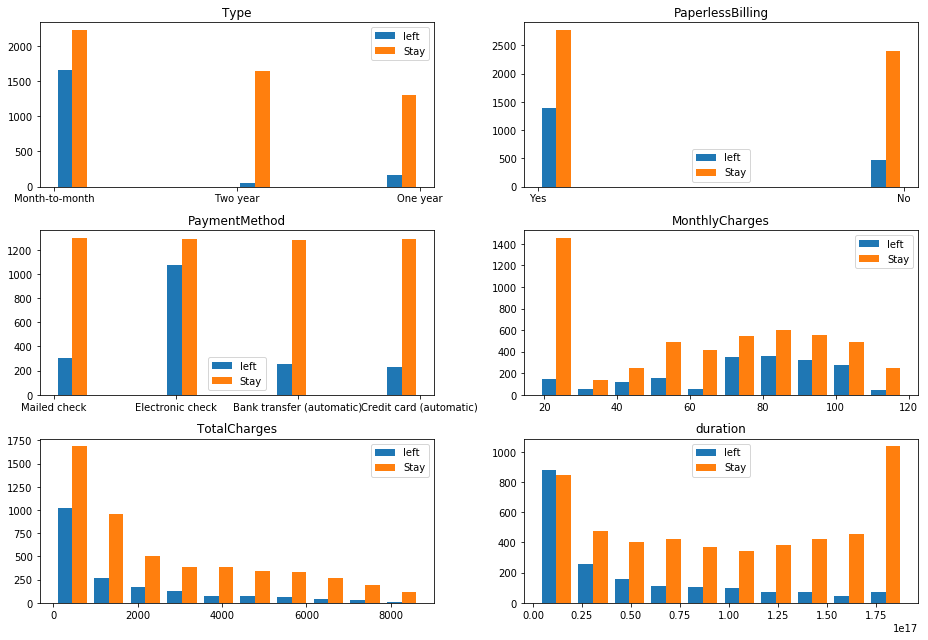

In [17]:
#### plot personal data
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13,9))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()
axeses=[ax0, ax1, ax2, ax3, ax4, ax5]
labels = ['left', 'Stay']
for i in range(len(axeses)):
    column = contract.drop(['EndDate','BeginDate','left'], axis=1).columns[i]
    axeses[i].hist([contract[contract['left']==1][column],contract[contract['left']==0][column]], 
                    histtype='bar', label=labels)
    axeses[i].set_title(column)
    axeses[i].legend(loc='best')
fig.tight_layout()
plt.show()

> **Type:** It's clear that in Month-tomonth there are much more lefts. We can split it to month-tomonth VS year or two. <br/>
**PaperlessBiling:** It doesn't look like there is a differance here. this feature may be unnecessary. option: remove it. <br/>
**Payment Method:** as in type - Electronic check VS else. <br/>
**Monthly charge:** this is interesting, people who pay very little (20) leave less! but the rest is approx the same distribution. This should have a further investigation. <br/>
**Total charges:** very similar distribution. But, if the monthly charge is differant and also duration, what does it mean?<br>
**Duration:** from a brief look, the precentage of people who left is going smaller as they have the subscription for longer time. Not surprising, should make a graph of precentage.



                                                


In [18]:
contract['month-to-month'] = contract['Type'].apply(lambda x: 1 if x=='Month-to-month' else 0) # splitting the type.
contract['electronic-check'] = contract['PaymentMethod'].apply(lambda x: 1 if x=='Electronic check' else 0) # splitting payment method

In [19]:
#checking if paperless billing is defferant.
results = st.ttest_ind(contract[contract['PaperlessBilling']=='Yes']['left'] , contract[contract['PaperlessBilling']=='No']['left'], equal_var = False)
print('P-value is', results.pvalue)
if results.pvalue < 0.01:
    print('There is a differance with a certaincy of alpha 1%')
elif results.pvalue < 0.05:
    print('There is a differance with a certaincy of alpha 5%')
else:
    print('There is no differance')

P-value is 3.204065548489235e-64
There is a differance with a certaincy of alpha 1%


## Personal Data

In [20]:
pd.get_dummies(personal, drop_first=True).corrwith(contract['left'])

SeniorCitizen     0.150541
gender_Male      -0.008545
Partner_Yes      -0.149982
Dependents_Yes   -0.163128
dtype: float64

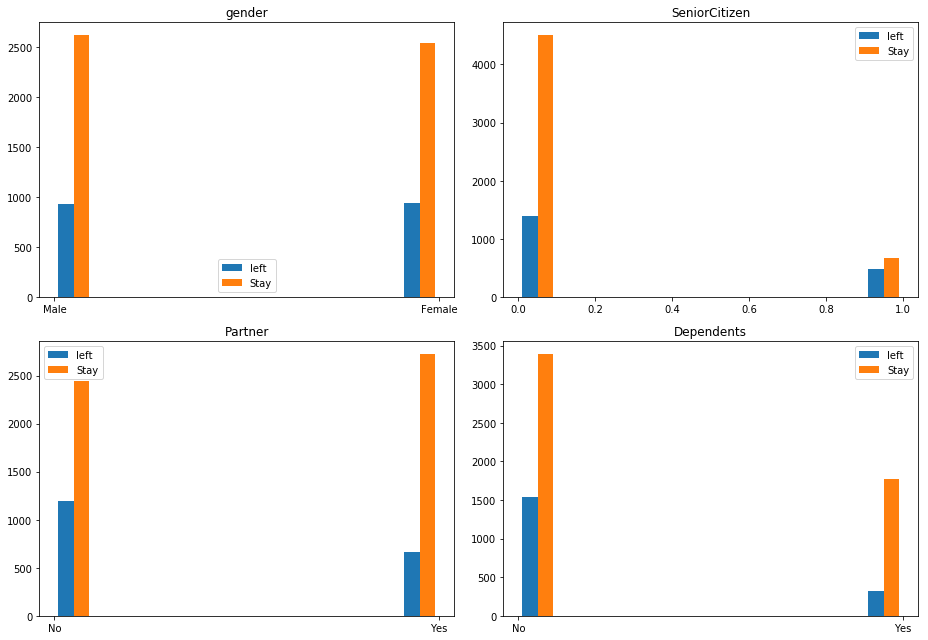

In [21]:
#### plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13,9))
ax0, ax1, ax2, ax3 = axes.flatten()
axeses=[ax0, ax1, ax2, ax3]
labels = ['left', 'Stay']
df = personal.join(contract['left'])
for i in range(len(axeses)):
    column = personal.columns[i]
    axeses[i].hist([df[df['left']==1][column], df[df['left']==0][column]], 
                    histtype='bar', label=labels)
    axeses[i].set_title(column)
    axeses[i].legend(loc='best')
fig.tight_layout()
plt.show()

**Gender:** No significant difference. <br/>
**Senior:** Much less senior in general but they are leaving more. <br/>
**Partner:** with no partner leave less. <br/>
**Depends** much more people with no dependents.


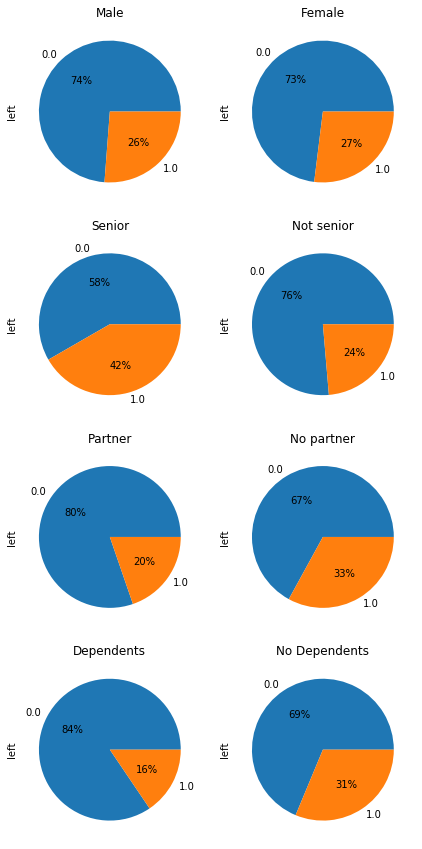

In [22]:
plt.subplots(nrows=4, ncols=2, figsize=(7,15))
plt.subplot(4, 2, 1)
df[df['gender'] == 'Male']['left'].value_counts().plot(kind='pie', ax=plt.gca(), title='Male',autopct='%1.f%%')
plt.subplot(4, 2, 2)
df[df['gender'] == 'Female']['left'].value_counts().plot(kind='pie', ax=plt.gca(), title='Female',autopct='%1.f%%')
plt.subplot(4, 2, 3)
df[df['SeniorCitizen'] == 1]['left'].value_counts().plot(kind='pie', ax=plt.gca(), title='Senior',autopct='%1.f%%')
plt.subplot(4, 2, 4)
df[df['SeniorCitizen'] == 0]['left'].value_counts().plot(kind='pie', ax=plt.gca(), title='Not senior',autopct='%1.f%%')
plt.subplot(4, 2, 5)
df[df['Partner'] == 'Yes']['left'].value_counts().plot(kind='pie', ax=plt.gca(), title='Partner',autopct='%1.f%%')
plt.subplot(4, 2, 6)
df[df['Partner'] == 'No']['left'].value_counts().plot(kind='pie', ax=plt.gca(), title='No partner',autopct='%1.f%%')
plt.subplot(4, 2, 7)
df[df['Dependents'] == 'Yes']['left'].value_counts().plot(kind='pie', ax=plt.gca(), title='Dependents',autopct='%1.f%%')
plt.subplot(4, 2, 8)
df[df['Dependents'] == 'No']['left'].value_counts().plot(kind='pie', ax=plt.gca(), title='No Dependents',autopct='%1.f%%')

## Phone Data

In [23]:
pd.get_dummies(phone, drop_first=True).corrwith(contract['left'])

MultipleLines_Yes    0.040207
dtype: float64

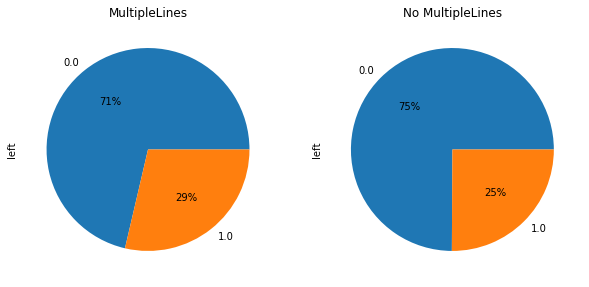

In [24]:
df=phone.join(contract['left'])

plt.subplots(nrows=1, ncols=2, figsize=(10,15))
plt.subplot(1, 2, 1)
df[df['MultipleLines'] == 'Yes']['left'].value_counts().plot(kind='pie', ax=plt.gca(), title='MultipleLines',autopct='%1.f%%')
plt.subplot(1, 2, 2)
df[df['MultipleLines'] != 'Yes']['left'].value_counts().plot(kind='pie', ax=plt.gca(), title='No MultipleLines',autopct='%1.f%%')

The correletion is low and also the difference.

## Internet Data

In [25]:
pd.get_dummies(internet, drop_first=True).corrwith(contract['left'])

InternetService_Fiber optic    0.243811
OnlineSecurity_Yes            -0.280508
OnlineBackup_Yes              -0.195758
DeviceProtection_Yes          -0.176806
TechSupport_Yes               -0.274112
StreamingTV_Yes               -0.036698
StreamingMovies_Yes           -0.040525
dtype: float64

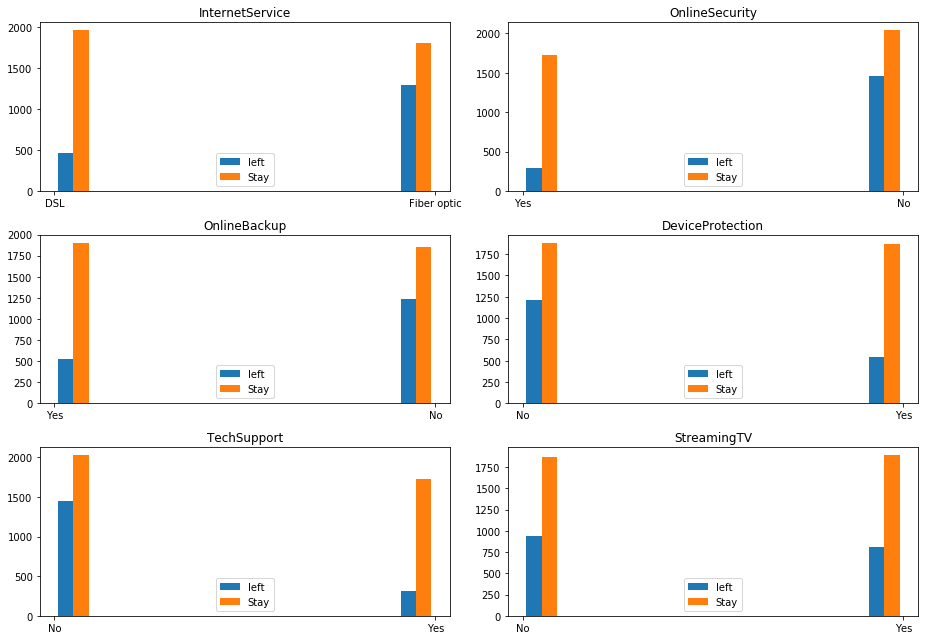

In [26]:
#### plotting
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13,9))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()
axeses=[ax0, ax1, ax2, ax3, ax4, ax5]
labels = ['left', 'Stay']
for i in range(len(axeses)):
    column = internet.columns[i]
    df = internet.join(contract['left'])
    axeses[i].hist([df[df['left']==1][column], df[df['left']==0][column]], 
                    histtype='bar', label=labels)
    axeses[i].set_title(column)
    axeses[i].legend(loc='best')
fig.tight_layout()
plt.show()

Clients are less likely to leave if they have additional product - this should get a further investigation (A/B testing or other) to check if they are staying because of the addtional product or more loyal clients take addtional products... <br/>
What is the problem whith the fiber optic??

## Differances between phone and internet subscribers.

In [27]:
#United data frame
phone['phone'] = 1
internet['internet'] = 1
full = contract.join([personal, phone, internet]).drop(['BeginDate', 'EndDate','Type'], axis=1)
full['both'] = full[(full['phone']==1) & (full['internet']==1)]['phone'] #both internet and phone
full['phone only'] = full[(full['phone']==1) & (full['internet']!=1)]['phone'] #only phone
full['internet only'] = full[(full['phone']!=1) & (full['internet']==1)]['internet'] #only internet
full.fillna(0, inplace=True)

In [28]:
full.describe()

,MonthlyCharges,TotalCharges,left,duration,month-to-month,electronic-check,SeniorCitizen,phone,internet,both,phone only,internet only
count,7032.000000,7032.000000,7032.000000,7.032000e+03,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,64.798208,2283.300441,0.265785,8.532333e+16,0.551052,0.336320,0.162400,0.903299,0.783845,0.687144,0.216155,0.096701
std,30.085974,2266.771362,0.441782,6.455408e+16,0.497422,0.472483,0.368844,0.295571,0.411650,0.463689,0.411650,0.295571
min,18.250000,18.800000,0.000000,2.592000e+15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.587500,401.450000,0.000000,2.376000e+16,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,70.350000,1397.475000,0.000000,7.629120e+16,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,89.862500,3794.737500,1.000000,1.448064e+17,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,118.750000,8684.800000,1.000000,1.893024e+17,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


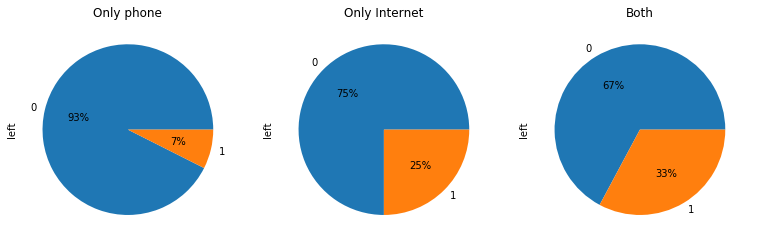

In [29]:
#Pie plots of precentage of leaving in the different sectors
plt.subplots(nrows=1, ncols=3, figsize=(13,9))
plt.subplot(1, 3, 1)
full[(full['phone only']==1)]['left'].value_counts().plot(kind='pie', ax=plt.gca(), title='Only phone',autopct='%1.f%%')
plt.subplot(1, 3, 2)
full[(full['internet only']==1)]['left'].value_counts().plot(kind='pie', ax=plt.gca(), title='Only Internet',autopct='%1.f%%')
plt.subplot(1, 3, 3)
full[full['both']==1]['left'].value_counts().plot(kind='pie', ax=plt.gca(), title='Both',autopct='%1.f%%')

Text(0.5, 1.0, 'Monthly Cherges: Stayed vs Left')

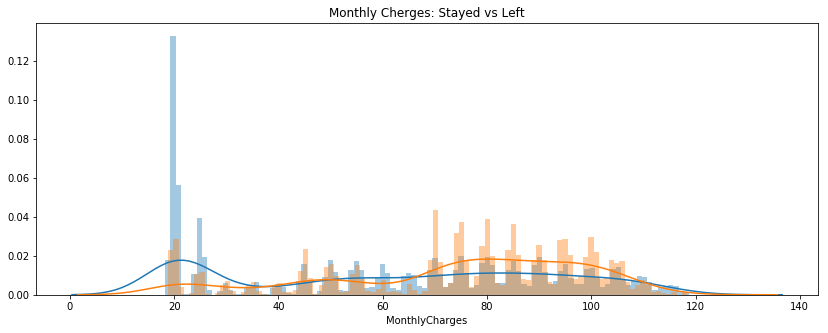

In [30]:
# A dipper look in the differances in monthly charges
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 5))
sns.distplot(contract[contract['left']==0]['MonthlyCharges'], bins=100, ax=axes, label='Stay')
sns.distplot(contract[contract['left']==1]['MonthlyCharges'], bins=100, ax=axes, label='Left')
axes.set_title('Monthly Cherges: Stayed vs Left')

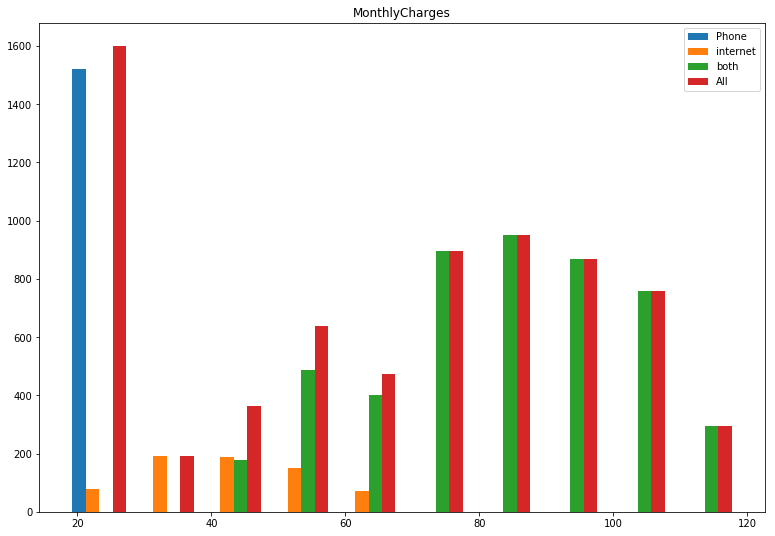

In [31]:
#same, all together
plt.subplots(figsize=(13,9))

plt.hist([full[full['phone only']==1]['MonthlyCharges'],
          full[full['internet only']==1]['MonthlyCharges'],
          full[full['both']==1]['MonthlyCharges'],
          full['MonthlyCharges']], 
         histtype='bar', label=['Phone','internet','both','All'])
plt.title('MonthlyCharges')
plt.legend(loc='best')

fig.tight_layout()
plt.show()

This is the reason why people who pay around 20 are less likely to leave - they are phone users - which are are less likely to leave. let's check that.

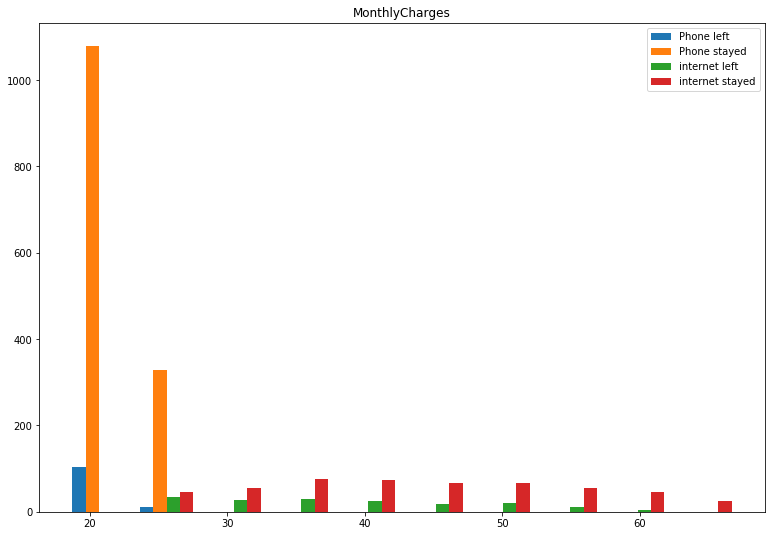

In [32]:
#Distribution of monthly charge by phone/internet left/stayed
plt.subplots(figsize=(13,9))

plt.hist([full[(full['phone only']==1) & (full['left']==1)]['MonthlyCharges'],
          full[(full['phone only']==1) & (full['left']==0)]['MonthlyCharges'],
          full[(full['internet only']==1) & (full['left']==1)]['MonthlyCharges'],
          full[(full['internet only']==1) & (full['left']==0)]['MonthlyCharges']], 
         histtype='bar', label=['Phone left','Phone stayed', 'internet left','internet stayed'])
plt.title('MonthlyCharges')
plt.legend(loc='best')

fig.tight_layout()
plt.show()

Now, it doesn't look like there are significant differences in monthly charges between left and not.

# Creating Models

In [33]:
full_data = pd.get_dummies(full, drop_first=True) # adjusting the dataset for modeling
#splitting data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(full_data.drop(['left'],axis=1), full_data['left'], random_state=42)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state=42)

In [34]:
#linear classifier
lr = LogisticRegression(solver='liblinear', random_state=12345)
lr.fit(X_train, y_train)
print('ROC AUC', '{:.2f}'.format(roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])))
print('Accuracy', '{:.2f}'.format(accuracy_score(y_test, lr.predict(X_test))))

ROC AUC 0.74
Accuracy 0.74


In [35]:
#Gradient boost
gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)
print('ROC AUC', '{:.2f}'.format(roc_auc_score(y_test, gbc.predict_proba(X_test)[:,1])))
print('Accuracy', '{:.2f}'.format(accuracy_score(y_test, gbc.predict(X_test))))

ROC AUC 0.87
Accuracy 0.84


We saw before that the data is imbalnced, let's try to upsample it.

In [36]:
def upsample(features, target, repeat): #upsampling function for 1s
    #splitting the data to 0 and 1:
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    #multiply the 1s and concatenate
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345) #adding randomization by shuffling
    
    return features_upsampled, target_upsampled

In [37]:
#upsample the trainning set. and checking the new balance
X_upsampled, y_upsampled = upsample(X_train, y_train, 3)
y_upsampled.mean()

0.522850790513834

In [38]:
#linear classifier with upsampling
lr = LogisticRegression(solver='liblinear', random_state=12345)
lr.fit(X_upsampled, y_upsampled)
print('ROC AUC', '{:.2f}'.format(roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])))
print('Accuracy', '{:.2f}'.format(accuracy_score(y_test, lr.predict(X_test))))

ROC AUC 0.74
Accuracy 0.74


In [39]:
#Gradient boost with upsampling
gbc = GradientBoostingClassifier()
gbc.fit(X_upsampled, y_upsampled)
print('ROC AUC', '{:.2f}'.format(roc_auc_score(y_test, gbc.predict_proba(X_test)[:,1])))
print('Accuracy', '{:.2f}'.format(accuracy_score(y_test, gbc.predict(X_test))))

ROC AUC 0.87
Accuracy 0.77


No improvement.

In [40]:
#Now, for tuning hyperparameters, using validation set.
RFC = [['n estimators', 'max depth', 'AUC ROC', 'accuracy score']]
for estim in range(20, 70, 10): #Hyperparameters tuning
    for depth in range(10, 20, 2):
        model = RandomForestClassifier(n_estimators=estim, max_depth=depth, random_state=12345)
        model.fit(X_tr, y_tr)
        RFC.append([estim, depth, roc_auc_score(y_val, model.predict_proba(X_val)[:,1]), accuracy_score(y_val, model.predict(X_val))]) 

RFC_df = pd.DataFrame(data=RFC[1:], columns=RFC[0]).sort_values(by='AUC ROC', ascending=False).reset_index()  #Results sorted by F1 score.
RFC_df.head()

,index,n estimators,max depth,AUC ROC,accuracy score
0,15,50,10,0.858275,0.813495
1,10,40,10,0.856828,0.811979
2,20,60,10,0.856727,0.817286
3,5,30,10,0.856647,0.818802
4,21,60,12,0.855933,0.816528


In [41]:
#Running the model with the best hyperparameters.
model = RandomForestClassifier(n_estimators=60, max_depth=10, random_state=12345)
model.fit(X_train, y_train)
print('ROC AUC', '{:.2f}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
print('Accuracy', '{:.2f}'.format(accuracy_score(y_test, model.predict(X_test))))

ROC AUC 0.84
Accuracy 0.81


In [42]:
#Tuning hyperparameters for LGB using cross validation
print('n_estim | leaves | ROC AUC ')
for n in range(200, 400, 100):
    for l in range(150, 350, 100):
        model = lgb.LGBMClassifier(n_estimators=n, num_leaves=l)
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
        print('{}     |  {} | {:,.2f}'.format(n, l, scores.mean()))

n_estim | leaves | ROC AUC 
200     |  150 | 0.88
200     |  250 | 0.88
300     |  150 | 0.88
300     |  250 | 0.88


In [43]:
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print('ROC AUC', '{:.2f}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
print('Accuracy', '{:.2f}'.format(accuracy_score(y_test, model.predict(X_test))))

ROC AUC 0.89
Accuracy 0.84


In [44]:
#Catboost
model = CatBoostClassifier()
model.fit(X_train, y_train, silent=True)
predictions = model.predict(X_test)
print('ROC AUC', '{:.2f}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
print('Accuracy', '{:.2f}'.format(accuracy_score(y_test, model.predict(X_test))))

ROC AUC 0.89
Accuracy 0.85


In [45]:
# Not all the components are good for the model prediction as we saw. for that we have PCA:
for i in range(1,16):
    pca = PCA(n_components=i, svd_solver='arpack')
    pca.fit(X_tr, y_tr)
    val_trans = pca.transform(X_val)
    tr_trans = pca.transform(X_tr)
    model = lgb.LGBMClassifier()
    model.fit(tr_trans, y_tr)
    print(i, 'ROC AUC', '{:.2f}'.format(roc_auc_score(y_val, model.predict_proba(val_trans)[:,1])))

1 ROC AUC 0.91
2 ROC AUC 0.89
3 ROC AUC 0.89
4 ROC AUC 0.88
5 ROC AUC 0.89
6 ROC AUC 0.89
7 ROC AUC 0.88
8 ROC AUC 0.89
9 ROC AUC 0.88
10 ROC AUC 0.87
11 ROC AUC 0.87
12 ROC AUC 0.87
13 ROC AUC 0.87
14 ROC AUC 0.87
15 ROC AUC 0.87


In [46]:
#only 1 component is enough! 
pca = PCA(n_components=1, svd_solver='arpack')
pca.fit(X_train, y_train)
val_trans = pca.transform(X_test)
tr_trans = pca.transform(X_train)
model = lgb.LGBMClassifier()
model.fit(tr_trans, y_train)

print('ROC AUC', '{:.2f}'.format(roc_auc_score(y_test, model.predict_proba(val_trans)[:,1])))
print('Accuracy', '{:.2f}'.format(accuracy_score(y_test, model.predict(val_trans))))

ROC AUC 0.90
Accuracy 0.86


In [47]:
pca = PCA(n_components=1, svd_solver='arpack')
pca.fit(X_train, y_train)
val_trans = pca.transform(X_test)
tr_trans = pca.transform(X_train)
model = CatBoostClassifier()
model.fit(tr_trans, y_train, silent=True)

print('ROC AUC', '{:.2f}'.format(roc_auc_score(y_test, model.predict_proba(val_trans)[:,1])))
print('Accuracy', '{:.2f}'.format(accuracy_score(y_test, model.predict(val_trans))))

ROC AUC 0.90
Accuracy 0.87


## Conclusion

The Best models was Catboost, using 1 component - with 0.9 ROC AUC and accuracy of 0.87. <br/>

* The PCA analysis showed that the best regression score was with only 1 component - this needs a further investigatin - there is somthing that makes customer leave, maybe it's the pricing or a bad product?
* The company should consider different approaches to the different client sector - their behavior is different.
* In addition, they should consider partner's discount, and other programs that are significantly more stable.